# Introduction: 
## Extract the path of particle tracking outputs
Following code read the outputs of particle tracking and extracts the latitude and longitude 

### Part1: Required Imports

In [10]:
# Importing libraries
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.dates as mdates
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import re 
import pylag
from shapely.geometry import Point
import contextily as ctx
import datetime

#### Part1.1:Define Path to pylags output nc files

In [11]:
#define a path to the FVCOME data directory /home/samin/data/FVCOME_OUTPUT/Gldata/FVCOMEDATA
# go forlder 202301 and red nc file contain *2230101.nc
# define the path to the data directory
data_dir = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/Jan'

#### Part1.2: Reading Outpufiles

In [12]:
# Custom sorting function
def sort_key(file):
    # Extract the filename from the file path
    filename = os.path.basename(file)
    # Extract the number from the filename
    number = int(filename.split('__')[1].split('.')[0])
    return number

# Get the output files and sort them using lamda function
files = glob.glob(os.path.join(data_dir, 'Fvcome_huron_estuary_2023_Winter__*.nc'))
files.sort(key=sort_key)

# Read all the nc files into a list of xarray datasets and sort them by time 
datasets = [xr.open_mfdataset(file) for file in files]

In [13]:
# from datasets, read datasets[0] and datasets[-1] 
# extract the value of latitude and longitude
# extract the value of time
# plot latitude and longitude vs time for datasets[0] and datasets[-1] with different color

# Extract the latitude, longitude, and time from the first dataset
lat0 = datasets[0].latitude.values
lon0 = datasets[0].longitude.values
time0 = datasets[0].time.values

# Extract the latitude, longitude, and time from the last dataset
lat1 = datasets[-1].latitude.values
lon1 = datasets[-1].longitude.values
time1 = datasets[-1].time.values


In [14]:
# Expand the code to be able to read the latitude, longitude, and time for all the datasets
# Read the latitude, longitude, and time for all the datasets
lat = [dataset.latitude.values for dataset in datasets]
lon = [dataset.longitude.values for dataset in datasets]
time = [dataset.time.values for dataset in datasets]
group_id = [dataset.group_id.values for dataset in datasets]

In [15]:
import pandas as pd

# Function to flatten nested lists
def flatten(lst):
    for item in lst:
        if isinstance(item, list):
            yield from flatten(item)
        else:
            yield item

# Flatten the list
flat_times = list(flatten(time))

# Print types of elements to ensure they are strings or datetime objects
for item in flat_times:
    print(type(item), item)

# Convert to DateTimeIndex
time_index = pd.to_datetime(flat_times)

print(time_index)


<class 'numpy.ndarray'> ['2023-01-01T00:00:00.000000000' '2023-01-01T06:00:00.000000000'
 '2023-01-01T12:00:00.000000000' '2023-01-01T18:00:00.000000000'
 '2023-01-02T00:00:00.000000000' '2023-01-02T06:00:00.000000000'
 '2023-01-02T12:00:00.000000000' '2023-01-02T18:00:00.000000000'
 '2023-01-03T00:00:00.000000000' '2023-01-03T06:00:00.000000000'
 '2023-01-03T12:00:00.000000000' '2023-01-03T18:00:00.000000000'
 '2023-01-04T00:00:00.000000000' '2023-01-04T06:00:00.000000000'
 '2023-01-04T12:00:00.000000000' '2023-01-04T18:00:00.000000000'
 '2023-01-05T00:00:00.000000000' '2023-01-05T06:00:00.000000000'
 '2023-01-05T12:00:00.000000000' '2023-01-05T18:00:00.000000000'
 '2023-01-06T00:00:00.000000000' '2023-01-06T06:00:00.000000000'
 '2023-01-06T12:00:00.000000000' '2023-01-06T18:00:00.000000000'
 '2023-01-07T00:00:00.000000000' '2023-01-07T06:00:00.000000000'
 '2023-01-07T12:00:00.000000000' '2023-01-07T18:00:00.000000000'
 '2023-01-08T00:00:00.000000000' '2023-01-08T06:00:00.000000000'
 

TypeError: arg must be a string, datetime, list, tuple, 1-d array, or Series

# Part2: Extract variable

#### Part2-1: Test to make a dataframe. Prepare Dataset and ensure we have the combined GeoDatafram

In [17]:
#get the last output file in the dataset 
ds = datasets[-1]
#get the particle id index 
group_id = ds['group_id'].values
#get lat, lon and time for the last time step 
lat = ds['latitude'].values
lon = ds['longitude'].values
time = ds['time'].values

In [18]:
# Convert the dataset to a DataFrame
df = ds[['latitude', 'longitude', 'group_id', 'time']].to_dataframe().reset_index()

# Ensure 'time' is in the DataFrame
if 'time' not in df.columns:
    raise KeyError("The 'time' column is missing from the DataFrame.")
# if lon > 0, then longitude = longitude - 360
df.loc[df['longitude'] > 0, 'longitude'] -= 360
# Inspect the DataFrame to check alignment
print(df.head(100))

         time  particles   latitude  longitude  group_id
0  2023-01-01          0  45.735062 -84.665833         0
1  2023-01-01          1  45.737061 -84.671844         0
2  2023-01-01          2  45.737061 -84.669830         0
3  2023-01-01          3  45.737061 -84.667847         0
4  2023-01-01          4  45.737061 -84.665833         0
..        ...        ...        ...        ...       ...
95 2023-01-01         95  45.743942 -84.824738         1
96 2023-01-01         96  45.743942 -84.822754         1
97 2023-01-01         97  45.743942 -84.820740         1
98 2023-01-01         98  45.745941 -84.836731         1
99 2023-01-01         99  45.745941 -84.834747         1

[100 rows x 5 columns]


In [19]:
# Initialize an empty GeoDataFrame with time as the index
time_index = pd.to_datetime(df['time'].unique())
gdf = gpd.GeoDataFrame(index=time_index)

In [20]:
# Initialize a list to store individual GeoDataFrames for each group_id
gdfs = []

unique_group_ids = df['group_id'].unique()

for gid in unique_group_ids:
    # Filter rows for the current group_id
    subset = df[df['group_id'] == gid][['time', 'longitude', 'latitude', 'group_id']]
    # if longitude is greater than > -0 convert it to longitude - 360
    subset.loc[subset['longitude'] > -0, 'longitude'] = subset.loc[subset['longitude'] > -0, 'longitude'] - 360
    # Ensure 'time' column is datetime
    subset['time'] = pd.to_datetime(subset['time'])
    subset['time'] = subset['time'].astype(str)
    # Create a GeoDataFrame for the subset
    subset_gdf = gpd.GeoDataFrame(subset, geometry=gpd.points_from_xy(subset.longitude, subset.latitude))
    
    # Append the subset GeoDataFrame to the list
    gdfs.append(subset_gdf)

# Combine all individual GeoDataFrames into one
combined_gdf = pd.concat(gdfs)

# Reset the index to time
combined_gdf.set_index('time', inplace=True)

# Ensure combined_gdf is correctly indexed and includes group_id
combined_gdf['group_id'] = combined_gdf['group_id']

# Set the GeoDataFrame's geometry
combined_gdf['geometry'] = combined_gdf.apply(lambda row: row.geometry, axis=1)

# Drop any columns that are not needed
combined_gdf = combined_gdf.drop(columns=[col for col in combined_gdf.columns if col.startswith('geometry_') and col != 'geometry'])
# convert datetime field to string 
#gdf['time'] = gdf.index.strftime('%Y-%m-%d %H:%M:%S')
# Ensure the final GeoDataFrame is correct
print(combined_gdf.tail(100))

                     longitude   latitude  group_id  \
time                                                  
2023-01-30 18:00:00 -83.507652  43.725464       147   
2023-01-30 18:00:00 -83.457794  43.742634       147   
2023-01-30 18:00:00 -83.433655  43.781532       147   
2023-01-30 18:00:00 -83.433746  43.781391       147   
2023-01-30 18:00:00 -83.431885  43.785561       147   
...                        ...        ...       ...   
2023-01-31 00:00:00 -83.497597  43.726089       147   
2023-01-31 00:00:00 -83.502037  43.726452       147   
2023-01-31 00:00:00 -83.519829  43.728039       147   
2023-01-31 00:00:00 -83.496582  43.727852       147   
2023-01-31 00:00:00 -83.431702  43.786091       147   

                                       geometry  
time                                             
2023-01-30 18:00:00  POINT (-83.50765 43.72546)  
2023-01-30 18:00:00  POINT (-83.45779 43.74263)  
2023-01-30 18:00:00  POINT (-83.43365 43.78153)  
2023-01-30 18:00:00  POINT (-83.43

In [21]:
# Save the GeoDataFrame to a shapefile called combined_gdf_Jan.shp
#combined_gdf_Feb = combined_gdf.copy()
combined_gdf.to_file('/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/Extracted_latlongeodataframe_Pylag/particle_tracking_Jan.shp')

In [ ]:
# save the geodataframe to a shapefile
combined_gdf.to_file('/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/Extracted_latlongeodataframe_Pylag/particle_tracking_Feb.shp')

In [ ]:
# save the data frame to a csv file
combined_gdf.to_csv('/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/Extracted_latlongeodataframe_Pylag/particle_tracking_Mar.csv')

#### Part2-3: Plotting Particle Tracing versus Group ID

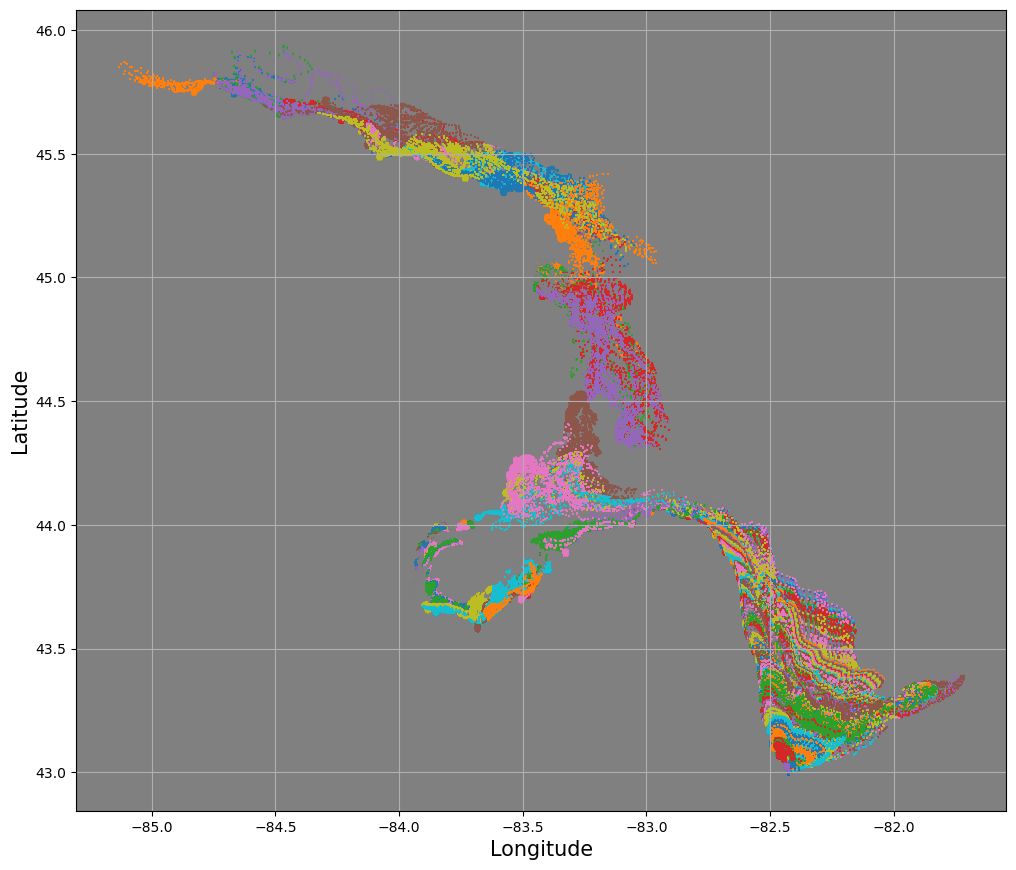

In [22]:
import matplotlib.pyplot as plt

# Create a figure and axis with a specified size
fig, ax = plt.subplots(1, 1, figsize=(12, 18))

# Plot each group_id with a different color
for gid in unique_group_ids:
    subset = combined_gdf[combined_gdf['group_id'] == gid]
    subset.plot(ax=ax, marker='_', label=f'Group {gid}', markersize=2)

# Add a legend with a specified font size
#plt.legend(fontsize=15)

# Add title and labels with specified font sizes
#plt.title('Particle Trajectories along the Huron Jan', fontsize=20)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)

# Add grid and background color
plt.grid(True)
plt.gca().set_facecolor('grey')

# Save the figure
plt.savefig('/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/results/particle_tracking_Jan.png')

# Show the plot
plt.show()

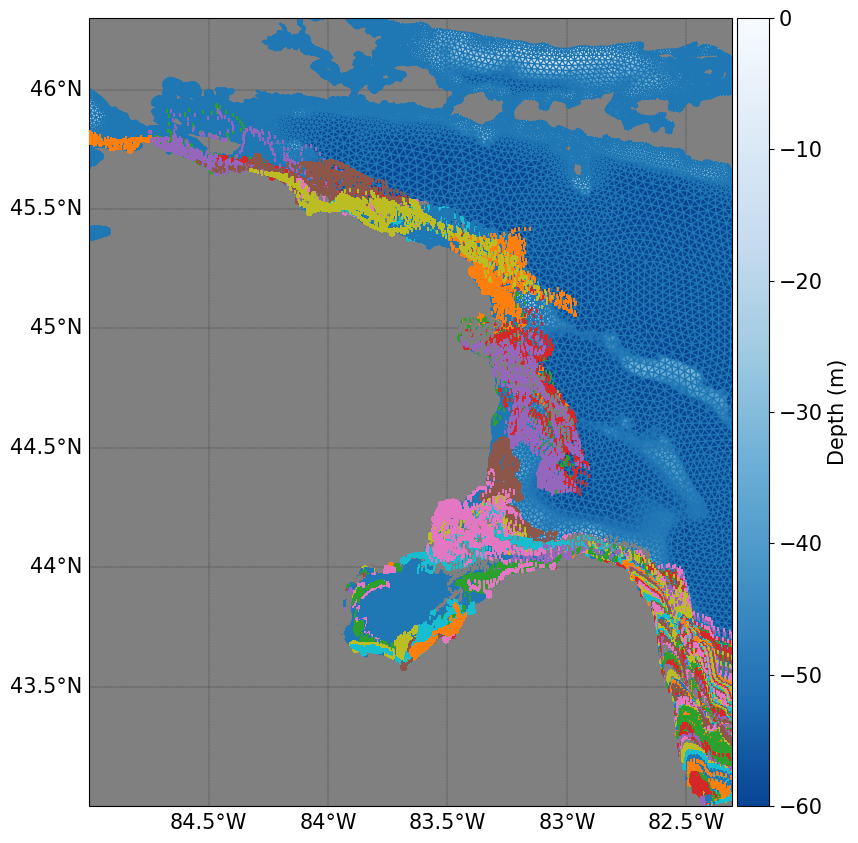

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from netCDF4 import Dataset
import cartopy.crs as ccrs
from pylag.processing.plot import FVCOMPlotter
from pylag.processing.plot import create_figure, colourmap
# Define a list of pink shades for the colormap
pink_shades = ['#fff5f7', '#ffebf0', '#ffd6e1', '#ffbfd4', '#ff99c1', '#ff6ea9', '#ff4c92', '#ff2171', '#b50d4e']
# Create a custom colormap
pink_cmap = LinearSegmentedColormap.from_list('custom_pink', pink_shades)

# Define a list of blue shades for the colormap and reverse it
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue_reversed', blue_shades_reversed)

# Define a list of green shades for the colormap
green_shades = ['#e8f5e9', '#c8e6c9', '#a5d6a7', '#81c784', '#66bb6a', '#4caf50', '#43a047', '#388e3c', '#2e7d32']
# Create a custom colormap
green_cmap = LinearSegmentedColormap.from_list('custom_green', green_shades)

# Create a custom colormap
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue_reversed', blue_shades_reversed)
font_size = 15
cmap = colourmap('h_r')

# Create the figure and axis with FVCOM plotter
fig, ax = create_figure(figure_size=(26.,26.),projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Load bathymetry data
grid_metrics_file_name = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc'
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()
# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                       geographic_coords=True,
                       font_size=font_size)

# Plot bathymetry
#extents = np.array([-84.10,-84.20, 45.58,45.65], dtype=float)
#extensts = np.array([-84,-81.3, 43,46], dtype=float)
#Lake Huron Ausable Point
extents = np.array([275, 277.69, 43, 46.3], dtype=float)
ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
                              cmap=blue_cmap_reversed, zorder= 0, vmin=-60, vmax=0)

# Overlay grid
plotter.draw_grid(ax, linewidth=1.0)

# Plot each group_id with a different color
for gid in unique_group_ids:
    subset = combined_gdf[combined_gdf['group_id'] == gid]
    subset.plot( ax = ax, marker='_', label=f'Group {gid}', markersize=2, zorder=40)

In [16]:
# print longitude min and max
print(combined_gdf['longitude'].min(), combined_gdf['longitude'].max())
print(combined_gdf['latitude'].min(), combined_gdf['latitude'].max())

-85.27877044677734 -82.39694213867188
42.99168014526367 45.924110412597656


# Part3: Find the Intersection of Coastal Wetland and Particle Tracking

### Part3-1: Read the shapefiles: coastal wetlands, Lake shore line buffer

In [24]:
# path to the shapefile
data_dir = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/results/shapefiles'
path = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output'
buffer_lh = gpd.read_file(os.path.join(data_dir, 'lh_shore_ESRI_100k_Buffer1000m_NAD1983.shp'))
CW = gpd.read_file(os.path.join(data_dir, 'wetland_connected_avg_inundation_Albers.shp'))
# convert the shapefile to a geodataframe
buffer_gdf = gpd.GeoDataFrame(buffer_lh)
CW_geo = gpd.GeoDataFrame(CW) 

In [25]:
par_jan = gpd.read_file(os.path.join(path, 'combined_gdf_Jan.shp'))
par_Feb = gpd.read_file(os.path.join(path, 'combined_gdf_Feb.shp'))
par_Mar = gpd.read_file(os.path.join(path, 'combined_gdf_Mar.shp'))

In [26]:
combined_gdf_Jan = gpd.GeoDataFrame(par_jan)
combined_gdf_Feb = gpd.GeoDataFrame(par_Feb)
combined_gdf_Mar = gpd.GeoDataFrame(par_Mar)

### Part3-2: Convert the geometry of shapefiles 

In [27]:
# Ensure the geodataframe is the same coordinates which is 3174 for Great Lakes Albers
# Set the original CRS of the GeoDataFrames because they particle tracking is lat/lon we first set it to 4326
combined_gdf_Jan = combined_gdf_Jan.set_crs(epsg=4326) # particle data
combined_gdf_Feb = combined_gdf_Feb.set_crs(epsg=4326) # particle data
combined_gdf_Mar = combined_gdf_Mar.set_crs(epsg=4326) # particle data

In [28]:
# to have the Great Lake Albers projection we re project it to Great lakes Albers
combined_gdf_Jan = combined_gdf_Jan.to_crs(epsg=3174)
combined_gdf_Feb = combined_gdf_Feb.to_crs(epsg=3174)
combined_gdf_Mar = combined_gdf_Mar.to_crs(epsg=3174)

In [29]:
# print the CRS of CW_geo
print("Coastal wetland", CW_geo.crs)
print ("Buffer", buffer_gdf.crs)
print("combined_gdf_Jan", combined_gdf_Jan.crs)
print("combined_gdf_Feb", combined_gdf_Feb.crs)
print("combined_gdf_Mar", combined_gdf_Mar.crs)

Coastal wetland EPSG:3174
Buffer EPSG:3174
combined_gdf_Jan EPSG:3174
combined_gdf_Feb EPSG:3174
combined_gdf_Mar EPSG:3174


### Part 3-2-1: Reading Grid file from Pylag 

In [30]:
import os
#data_dir = '/home/samin/data/FVCOME_OUTPUT/Gldata/FVCOMEDATA/202301'.format(os.environ['HOME'])
data_dir='/home/abolmaal/data/FVCOME_OUTPUT/Gldata/FVCOMEDATA/202301'.format(os.environ['HOME']) 
# Create run directory
cwd = os.getcwd()
# Create run directory
simulation_dir = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron'.format(cwd)
try:
    os.makedirs(simulation_dir)
except FileExistsError:
    pass

# Create input sub-directory
input_dir = '{}/input'.format(simulation_dir)
try:
    os.makedirs(input_dir)
except FileExistsError:
    pass
grid_metrics_file_name = f'{input_dir}/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc'

### Part 3-3: Find the intersection of polygon and Point 

In the Following section we will use geopandas spatial join to find the intersection for the particle tracking out put for:
1- between the lh_shore_ESRI_100k_Buffer1000m_WGS84 and particle tracking
2- Between wetland_connected_avg_Buffer (which is a 500 meter buffer for the coastal wetland) with Particle tracking 

### Find the average number of trajectories entering the shore line for the fisrt three month of Winter

Total number of intersections in Jan: 912813
    index_right  count
0             1     32
1             0     29
2            25     12
3             2      5
4            10      5
5             9      4
6            20      4
7            13      4
8             3      4
9            12      4
10           21      3
11            8      3
12            6      3
13           22      3
14            4      3
15           11      3
16           23      2
17           16      2
18           14      1
19           15      1
20           18      1
21            7      1
22           17      1
23            5      1
Average number of particles entering each polygon in Jan: 14.90360509992957


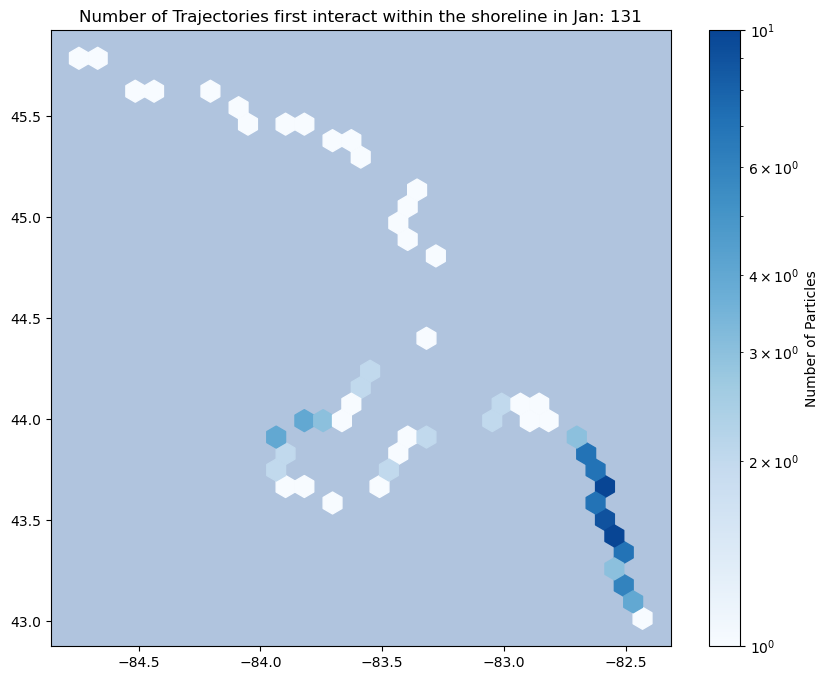

Total number of intersections in Feb: 721943
    index_right  count
0             1     32
1             0     29
2            25     12
3             2      5
4            10      5
5             9      4
6            20      4
7            13      4
8             3      4
9            12      4
10           21      3
11            8      3
12            6      3
13           22      3
14            4      3
15           11      3
16           23      2
17           16      2
18           14      1
19           15      1
20           18      1
21            7      1
22           17      1
23            5      1
Average number of particles entering each polygon in Feb: 14.759201845226364


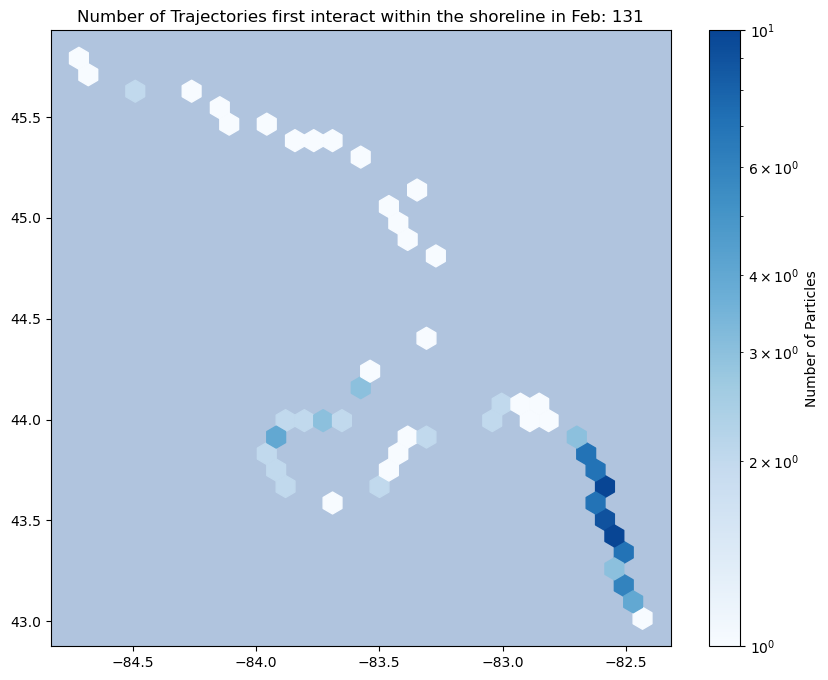

Total number of intersections in Mar: 1285962
    index_right  count
0             1     32
1             0     29
2            25     12
3             2      5
4            10      5
5             9      4
6            20      4
7            13      4
8             3      4
9            12      4
10           21      3
11            8      3
12            6      3
13           22      3
14            4      3
15           11      3
16           23      2
17           16      2
18           14      1
19           15      1
20           18      1
21            7      1
22           17      1
23            5      1
Average number of particles entering each polygon in Mar: 17.03492308254865


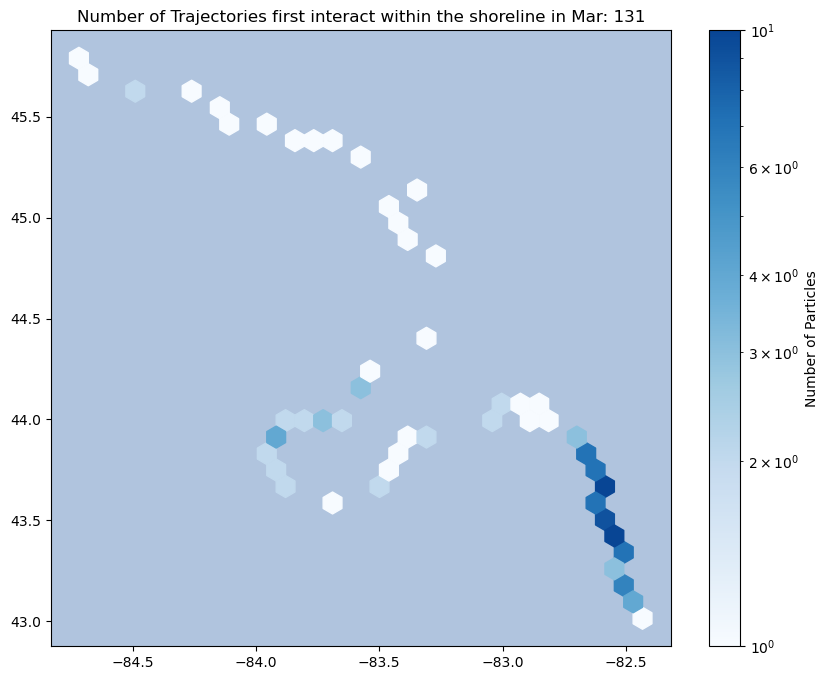

In [15]:

from matplotlib.colors import LinearSegmentedColormap
# Load your monthly GeoDataFrames
monthly_data = {
    'Jan': combined_gdf_Jan,
    'Feb': combined_gdf_Feb,
    'Mar': combined_gdf_Mar,
    # Add more months as needed
}
# Define a list of blue shades for the colormap
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
# Create a custom colormap
blue_cmap = LinearSegmentedColormap.from_list('custom_blue', blue_shades)

# Iterate over each month's data
for month, combined_gdf in monthly_data.items():
    # Ensure 'time' is a column and convert to datetime
    if 'time' in combined_gdf.index.names:
        combined_gdf.reset_index(inplace=True)
    combined_gdf['time'] = pd.to_datetime(combined_gdf['time'])
    # Perform spatial join to find which points fall within the polygons
    points_within_shoreline = gpd.sjoin(combined_gdf, buffer_gdf[['geometry']], how='inner', predicate='intersects')
    # Ensure 'time' is a column in the intersections and convert to datetime
    if 'time' in points_within_shoreline.index.names:
        points_within_shoreline.reset_index(inplace=True)
    points_within_shoreline['time'] = pd.to_datetime(points_within_shoreline['time'])
    # Sort the intersection by group_id and time
    points_within_shoreline = points_within_shoreline.sort_values(by=['group_id', 'time'])
    # Group by the group_id to find the first intersection for each particle
    first_intersections = points_within_shoreline.groupby(['group_id']).first().reset_index()
    
    # Count the total number of particles that intersected with the shoreline
    total_intersections = len(points_within_shoreline)
    print(f'Total number of intersections in {month}: {total_intersections}')
    
    # Count the number of particles entering each polygon (shoreline area)
    particle_counts = first_intersections['index_right'].value_counts().reset_index()
    particle_counts.columns = ['index_right', 'count']
    print(particle_counts)
    
    # Merge particle counts with the shoreline data to retain polygon information
    shoreline_with_counts = points_within_shoreline.merge(particle_counts, on='index_right', how='left')
    
    # Calculate the average number of particles entering each polygon
    average_particles_per_polygon = shoreline_with_counts['count'].mean()
    print(f'Average number of particles entering each polygon in {month}: {average_particles_per_polygon}')
    
    # Create the hexbin plot
    fig, ax = plt.subplots(figsize=(10, 8))
    hb = ax.hexbin(first_intersections['longitude'], first_intersections['latitude'], gridsize=30, cmap=blue_cmap, norm=colors.LogNorm())
    
    # Set the title of the colormap to the number of points that fall within the polygons
    num_points = len(first_intersections)
    ax.set_title(f'Number of Trajectories first interact within the shoreline in {month}: {num_points}')
    
    # Add a colorbar
    cbar = fig.colorbar(hb)
    cbar.set_label('Number of Particles')
    # Plot the polygons on top of the hexbin plot
    plt.gca().set_facecolor('lightsteelblue')
    # Plot the polygons on top of the hexbin plot
    #buffer_gdf.boundary.plot(ax=ax, edgecolor='black')
    
    # Show the plot
    plt.show()

### Calculating the average particles enter each polygone for the fisrt time calculate the average number of particles enter to the shoreline buffer and print how many percent of particles from the total trajectories remain in the shoreline

Average number of particles entering the shoreline buffer: 131.0
Percentage of particles from total trajectories that remain in the shoreline buffer: 0.99%


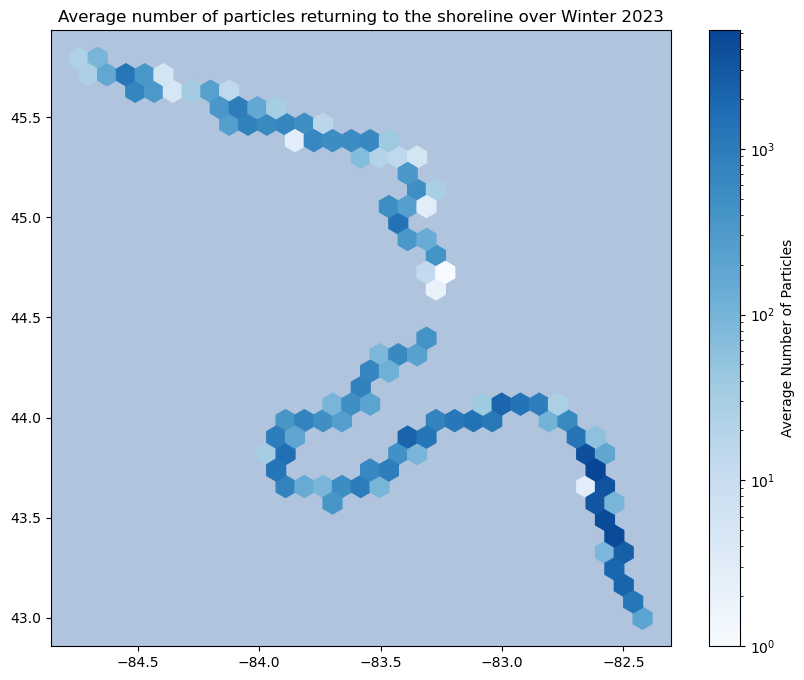

In [56]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm

# Load your monthly GeoDataFrames
monthly_data = {
    'Jan': combined_gdf_Jan,
    'Feb': combined_gdf_Feb,
    'Mar': combined_gdf_Mar,
    # Add more months as needed
}

# Buffer data

# DataFrame to store particle counts for each polygon across all months
all_particle_counts = pd.DataFrame(columns=['index_right', 'count'])

# Define a list of blue shades for the colormap
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
# Create a custom colormap
blue_cmap = LinearSegmentedColormap.from_list('custom_blue', blue_shades)

total_particles_intersecting_buffer = 0
total_particles_tracked = 0
points_within_shoreline_list = []
# Iterate over each month's data
for month, combined_gdf in monthly_data.items():
    # Ensure 'time' is a column and convert to datetime
    if 'time' in combined_gdf.index.names:
        combined_gdf.reset_index(inplace=True)
    combined_gdf['time'] = pd.to_datetime(combined_gdf['time'])
    
    # Perform spatial join to find which points fall within the polygons
    points_within_shoreline = gpd.sjoin(combined_gdf, buffer_gdf[['geometry']], how='inner', predicate='intersects')
    
    # Ensure 'time' is a column in the intersections and convert to datetime
    if 'time' in points_within_shoreline.index.names:
        points_within_shoreline.reset_index(inplace=True)
    points_within_shoreline['time'] = pd.to_datetime(points_within_shoreline['time'])
    
    # Sort the intersection by time to find the first intersection for all particles
    points_within_shoreline = points_within_shoreline.sort_values(by='time')
    
    # Get the first intersection for all particles
    first_intersections = points_within_shoreline.groupby('geometry').first().reset_index()
    
    # Count the number of particles entering each polygon (shoreline area)
    particle_counts = first_intersections['index_right'].value_counts().reset_index()
    particle_counts.columns = ['index_right', 'count']
    
    # Calculate the total number of particles that intersect the shoreline buffer
    total_particles_intersecting_buffer += first_intersections['group_id'].nunique()
    
    # Calculate the total number of particles tracked in the month
    total_particles_tracked += combined_gdf['group_id'].nunique()
    points_within_shoreline_list.append(first_intersections.shape[0])
# Calculate the average number of particles entering the shoreline buffer
average_particles_entering_buffer = total_particles_intersecting_buffer / len(monthly_data)

# Calculate the percentage of particles from the total trajectories that remain in the shoreline buffer
percentage_particles_remain_in_shoreline = (total_particles_intersecting_buffer / total_particles_tracked) 

print(f'Average number of particles entering the shoreline buffer: {average_particles_entering_buffer}')
print(f'Percentage of particles from total trajectories that remain in the shoreline buffer: {percentage_particles_remain_in_shoreline:.2f}%')

# Plot the average number of particles entering the shoreline buffer
fig, ax = plt.subplots(figsize=(10, 8))
#buffer_gdf.boundary.plot(ax=ax, edgecolor='black')

# Create the hexbin plot
hb = ax.hexbin(first_intersections['longitude'], first_intersections['latitude'], gridsize=30, cmap=blue_cmap, norm=LogNorm())

# Set the title of the colormap to the average number of particles that fall within the polygons
ax.set_title('Average number of particles returning to the shoreline over Winter 2023')

# Add a colorbar
cbar = fig.colorbar(hb)
cbar.set_label('Average Number of Particles')
plt.gca().set_facecolor('lightsteelblue')
# Show the plot
plt.show()


 to calculate how many of all the points first interact with the shoreline, we need to consider all individual points, not just those grouped by group_id. We'll determine the earliest interaction for each point within the points_within_shoreline DataFrame, and then calculate how many of these points first interact with the shoreline.

Average number of particles entering the shoreline buffer: 131.0
Percentage of points that first interact with the shoreline buffer: 438.46%


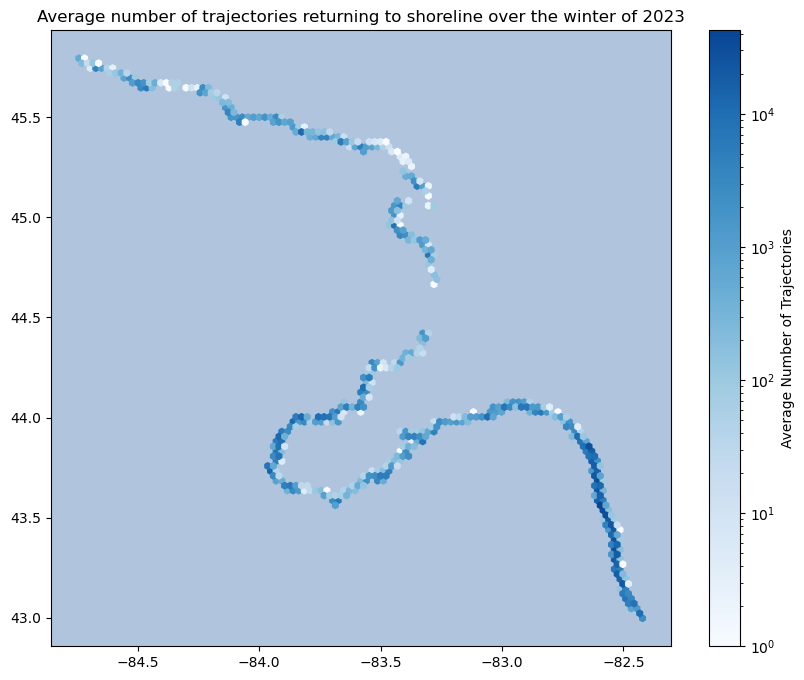

In [122]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm

# Load your monthly GeoDataFrames
monthly_data = {
    'Jan': combined_gdf_Jan,
    'Feb': combined_gdf_Feb,
    'Mar': combined_gdf_Mar,
    # Add more months as needed
}



# DataFrame to store particle counts for each polygon across all months
all_particle_counts = pd.DataFrame(columns=['index_right', 'count'])

# Define a list of blue shades for the colormap
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']

# Create a custom colormap
blue_cmap = LinearSegmentedColormap.from_list('custom_blue', blue_shades)

total_particles_intersecting_buffer = 0
total_points_first_interaction = 0

# Iterate over each month's data
for month, combined_gdf in monthly_data.items():
    # Ensure 'time' is a column and convert to datetime
    if 'time' in combined_gdf.index.names:
        combined_gdf.reset_index(inplace=True)
    combined_gdf['time'] = pd.to_datetime(combined_gdf['time'])
    
    # Perform spatial join to find which points fall within the polygons
    points_within_shoreline = gpd.sjoin(combined_gdf, buffer_gdf[['geometry']], how='inner', predicate='intersects')
    
    # Ensure 'time' is a column in the intersections and convert to datetime
    if 'time' in points_within_shoreline.index.names:
        points_within_shoreline.reset_index(inplace=True)
    points_within_shoreline['time'] = pd.to_datetime(points_within_shoreline['time'])
    
    # Sort the intersection by time to find the first intersection for all particles
    points_within_shoreline = points_within_shoreline.sort_values(by='time')
    
    # Calculate the total number of points that intersect the shoreline buffer
    total_points_first_interaction += points_within_shoreline.drop_duplicates(subset=['geometry']).shape[0]
    
    # Calculate the total number of particles intersecting the buffer
    total_particles_intersecting_buffer += points_within_shoreline['group_id'].nunique()
    
# Calculate the average number of particles entering the shoreline buffer
average_particles_entering_buffer = total_particles_intersecting_buffer / len(monthly_data)

# Calculate the percentage of points that first interact with the shoreline buffer
percentage_points_first_interaction = (total_points_first_interaction / total_particles_intersecting_buffer) 

print(f'Average number of particles entering the shoreline buffer: {average_particles_entering_buffer}')
print(f'Percentage of points that first interact with the shoreline buffer: {percentage_points_first_interaction:.2f}%')

# Plot the average number of particles entering the shoreline buffer
fig, ax = plt.subplots(figsize=(10, 8))
# Create the hexbin plot
hb = ax.hexbin(points_within_shoreline['longitude'], points_within_shoreline['latitude'], gridsize=100, cmap=blue_cmap, norm=LogNorm())

# Set the title of the colormap to the average number of particles that fall within the polygons
ax.set_title('Average number of trajectories returning to shoreline over the winter of 2023')

# Add a colorbar
cbar = fig.colorbar(hb)
cbar.set_label('Average Number of Trajectories')
plt.gca().set_facecolor('lightsteelblue')

# Show the plot
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Average number of particles entering the shoreline: 131.0
Percentage of particles from total trajectories that remain in the shoreline: 99.24%
Average number of particles in each bin:
Bin 0: 0.00 particles
Bin 1: 0.00 particles
Bin 2: 0.00 particles
Bin 3: 0.00 particles
Bin 4: 0.00 particles
Bin 5: 0.00 particles
Bin 6: 0.00 particles
Bin 7: 0.00 particles
Bin 8: 0.00 particles
Bin 9: 0.00 particles
Bin 10: 0.00 particles
Bin 11: 0.00 particles
Bin 12: 0.00 particles
Bin 13: 0.00 particles
Bin 14: 0.00 particles
Bin 15: 0.00 particles
Bin 16: 0.00 particles
Bin 17: 0.00 particles
Bin 18: 0.00 particles
Bin 19: 0.00 particles
Bin 20: 0.00 particles
Bin 21: 0.00 particles
Bin 22: 0.00 particles
Bin 23: 0.00 particles
Bin 24: 0.00 particles
Bin 25: 0.00 particles
Bin 26: 0.00 particles
Bin 27: 0.00 particles
Bin 28: 0.00 particles
Bin 29: 0.00 particles
Bin 30: 0.00 particles
Bin 31: 0.00 particles
Bin 32: 0.00 particles
Bin 33: 0.00 particles
Bin 34: 0.00 particles
Bin 35: 0.00 particle

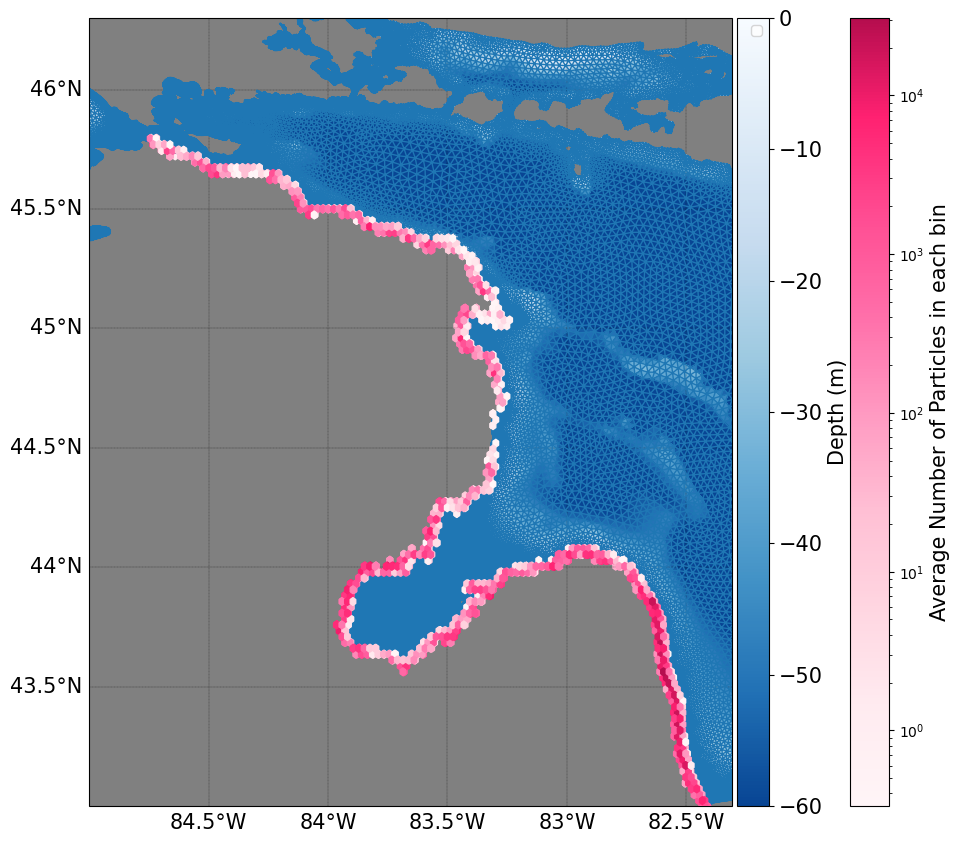

In [19]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import numpy as np
from pylag.processing.plot import FVCOMPlotter, create_figure, colourmap
import cartopy.crs as ccrs
from netCDF4 import Dataset
from pylag.processing.utils import get_grid_bands

# Load your monthly GeoDataFrames
monthly_data = {
    'Jan': combined_gdf_Jan,
    'Feb': combined_gdf_Feb,
    'Mar': combined_gdf_Mar,
    # Add more months as needed
}


# Ensure all GeoDataFrames use the same CRS
buffer_gdf_crs = buffer_gdf.crs

# DataFrame to store particle counts for each polygon across all months
all_particle_counts = pd.DataFrame(columns=['index_right', 'count'])

# Define a list of pink shades for the colormap
pink_shades = ['#fff5f7', '#ffebf0', '#ffd6e1', '#ffbfd4', '#ff99c1', '#ff6ea9', '#ff4c92', '#ff2171', '#b50d4e']
# Create a custom colormap
pink_cmap = LinearSegmentedColormap.from_list('custom_pink', pink_shades)

# Define a list of blue shades for the colormap and reverse it
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]
# Create a custom colormap
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue_reversed', blue_shades_reversed)


total_particles_intersecting_buffer = 0
total_particles_tracked = 0
points_within_shoreline_list = []
total_particles_list = []

# Store the hexbin data for each month to calculate the average
all_bin_counts = []

# Collect all coordinates for a consistent hexbin grid
all_coords = []

# Iterate over each month's data
for month, combined_gdf in monthly_data.items():
    # Ensure 'time' is a column and convert to datetime
    if 'time' in combined_gdf.index.names:
        combined_gdf.reset_index(inplace=True)
    combined_gdf['time'] = pd.to_datetime(combined_gdf['time'])
    
    # Perform spatial join to find which points fall within the coastal buffer
    points_within_shoreline = gpd.sjoin(combined_gdf, buffer_gdf[['geometry']], how='inner', predicate='intersects')
    
    # Ensure 'time' is a column in the intersections and convert to datetime
    if 'time' in points_within_shoreline.index.names:
        points_within_shoreline.reset_index(inplace=True)
    points_within_shoreline['time'] = pd.to_datetime(points_within_shoreline['time'])
    
    # Sort the intersection by time to find the first intersection for all particles
    points_within_shoreline = points_within_shoreline.sort_values(by='time')
    
    # Create a GeoDataFrame for the first intersections using the same CRS
    geometry = gpd.points_from_xy(points_within_shoreline['longitude'], points_within_shoreline['latitude'], crs=buffer_gdf_crs)
    first_intersections_shoreline = gpd.GeoDataFrame(points_within_shoreline, geometry=geometry, crs=buffer_gdf_crs)
    
    # Collect coordinates for hexbin grid
    all_coords.extend(zip(first_intersections_shoreline.geometry.x, first_intersections_shoreline.geometry.y))

font_size = 15
cmap = colourmap('h_r')

# Create the figure and axis with FVCOM plotter
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Load bathymetry data

ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)
extents = np.array([275, 277.69, 43, 46.3], dtype=float )
ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)', vmin=-60., vmax=0., cmap=blue_cmap_reversed, zorder= 0)

# Overlay grid= 
plotter.draw_grid(ax, linewidth=1.0)

# Create a hexbin plot to get the consistent grid
hb = ax.hexbin(*zip(*all_coords), gridsize=100, cmap=pink_cmap, norm=LogNorm())
hexbin_grid = hb.get_offsets()

# Initialize an array to accumulate bin counts
accumulated_bin_counts = np.zeros(len(hexbin_grid))

# Iterate over each month's data again to accumulate counts
for month, combined_gdf in monthly_data.items():
    # Ensure 'time' is a column and convert to datetime
    if 'time' in combined_gdf.index.names:
        combined_gdf.reset_index(inplace=True)
    combined_gdf['time'] = pd.to_datetime(combined_gdf['time'])
    
    # Perform spatial join to find which points fall within the coastal buffer
    points_within_shoreline = gpd.sjoin(combined_gdf, buffer_gdf[['geometry']], how='inner', predicate='intersects')
    
    # Ensure 'time' is a column in the intersections and convert to datetime
    if 'time' in points_within_shoreline.index.names:
        points_within_shoreline.reset_index(inplace=True)
    points_within_shoreline['time'] = pd.to_datetime(points_within_shoreline['time'])
    
    # Sort the intersection by time to find the first intersection for all particles
    points_within_shoreline = points_within_shoreline.sort_values(by='time')
    
    # Create a GeoDataFrame for the first intersections using the same CRS
    geometry = gpd.points_from_xy(points_within_shoreline['longitude'], points_within_shoreline['latitude'], crs=buffer_gdf_crs)
    first_intersections_shoreline = gpd.GeoDataFrame(points_within_shoreline, geometry=geometry, crs=buffer_gdf_crs)
    
    # Create a hexbin plot with the consistent grid and accumulate counts
    hb = ax.hexbin(first_intersections_shoreline.geometry.x, first_intersections_shoreline.geometry.y, gridsize=100, cmap=pink_cmap, norm=LogNorm(), reduce_C_function=np.sum, zorder=40)
    bin_counts = hb.get_array()
    for i, count in enumerate(bin_counts):
        accumulated_bin_counts[i] += count
    
    # Calculate the total number of particles that intersect the shoreline buffer
    total_particles_intersecting_buffer += first_intersections_shoreline['group_id'].nunique()
    
    # Calculate the total number of particles tracked in the month
    total_particles_tracked += combined_gdf['group_id'].nunique()
    total_particles_list.append(combined_gdf.shape[0])
    points_within_shoreline_list.append(first_intersections_shoreline.shape[0])

# Calculate the average bin counts
average_bin_counts = accumulated_bin_counts / len(monthly_data)

# Calculate the average number of particles entering the shoreline buffer
average_particles_entering_shoreline = total_particles_intersecting_buffer / len(monthly_data)

# Calculate the percentage of particles from the total trajectories that remain in the shoreline buffer
percentage_particles_remain_in_shoreline = (total_particles_intersecting_buffer / total_particles_tracked) * 100

print(f'Average number of particles entering the shoreline: {average_particles_entering_shoreline}')
print(f'Percentage of particles from total trajectories that remain in the shoreline: {percentage_particles_remain_in_shoreline:.2f}%')

# Update the hexbin plot with average bin counts
hb = ax.hexbin(*zip(*hexbin_grid), gridsize=100, C=average_bin_counts, cmap=pink_cmap, norm=LogNorm())

# Print the average number of particles in each bin
print("Average number of particles in each bin:")
for i, count in enumerate(average_bin_counts):
    print(f"Bin {i}: {count:.2f} particles")

# Set the title of the colormap to the average number of particles that fall within the polygons
#ax.set_title('Average number of particles returning to the shoreline over Winter 2023')

# Add x and y labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add a colorbar
cbar = fig.colorbar(hb, ax=ax, pad=0.09)
cbar.set_label('Average Number of Particles in each bin', fontsize=15)

# Adjust layout to make space for colorbar
plt.subplots_adjust(right=1)

# Add legend
plt.legend()

# Show the plot
plt.show()

Average number of particles entering the shoreline: 131.0
Percentage of particles from total trajectories that remain in the shoreline: 99.24%
Average number of particles in each bin:
Bin 0: 0.00 particles
Bin 1: 0.00 particles
Bin 2: 0.00 particles
Bin 3: 0.00 particles
Bin 4: 0.00 particles
Bin 5: 0.00 particles
Bin 6: 0.00 particles
Bin 7: 0.00 particles
Bin 8: 0.00 particles
Bin 9: 0.00 particles
Bin 10: 0.00 particles
Bin 11: 0.00 particles
Bin 12: 0.00 particles
Bin 13: 0.00 particles
Bin 14: 0.00 particles
Bin 15: 0.00 particles
Bin 16: 0.00 particles
Bin 17: 0.00 particles
Bin 18: 0.00 particles
Bin 19: 0.00 particles
Bin 20: 0.00 particles
Bin 21: 0.00 particles
Bin 22: 0.00 particles
Bin 23: 0.00 particles
Bin 24: 0.00 particles
Bin 25: 0.00 particles
Bin 26: 0.00 particles
Bin 27: 0.00 particles
Bin 28: 0.00 particles
Bin 29: 0.00 particles
Bin 30: 0.00 particles
Bin 31: 0.00 particles
Bin 32: 0.00 particles
Bin 33: 0.00 particles
Bin 34: 0.00 particles
Bin 35: 0.00 particle

Text(0.5, 1.0, 'Average number of particles returning to the shoreline over Winter 2023')

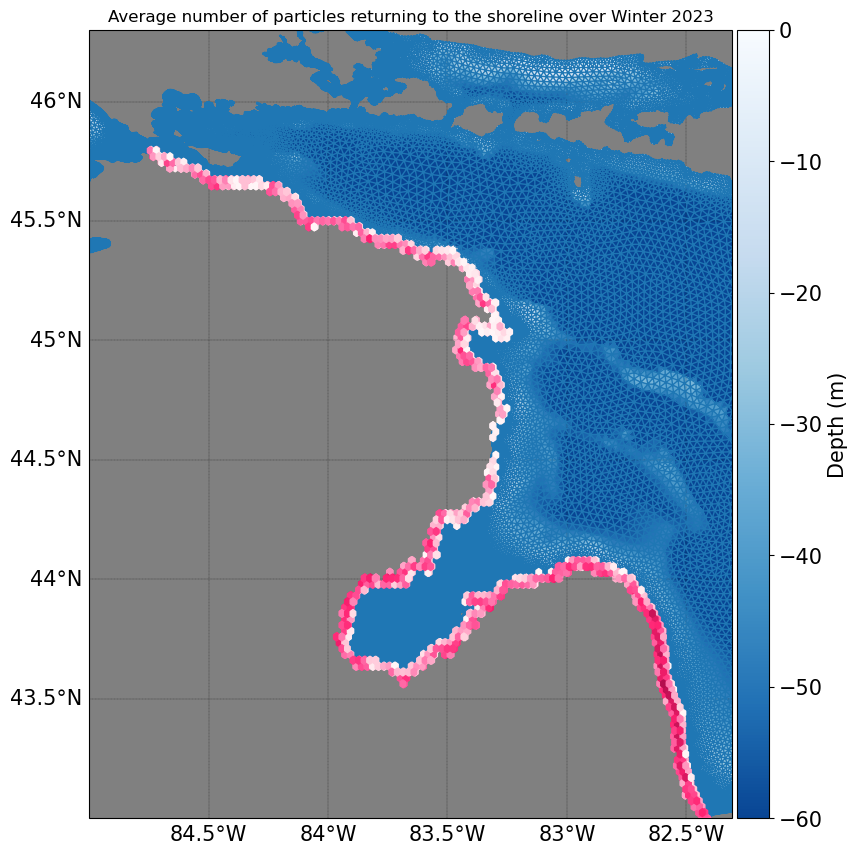

Average number of particles entering the shoreline: 131.0
Percentage of particles from total trajectories that remain in the shoreline


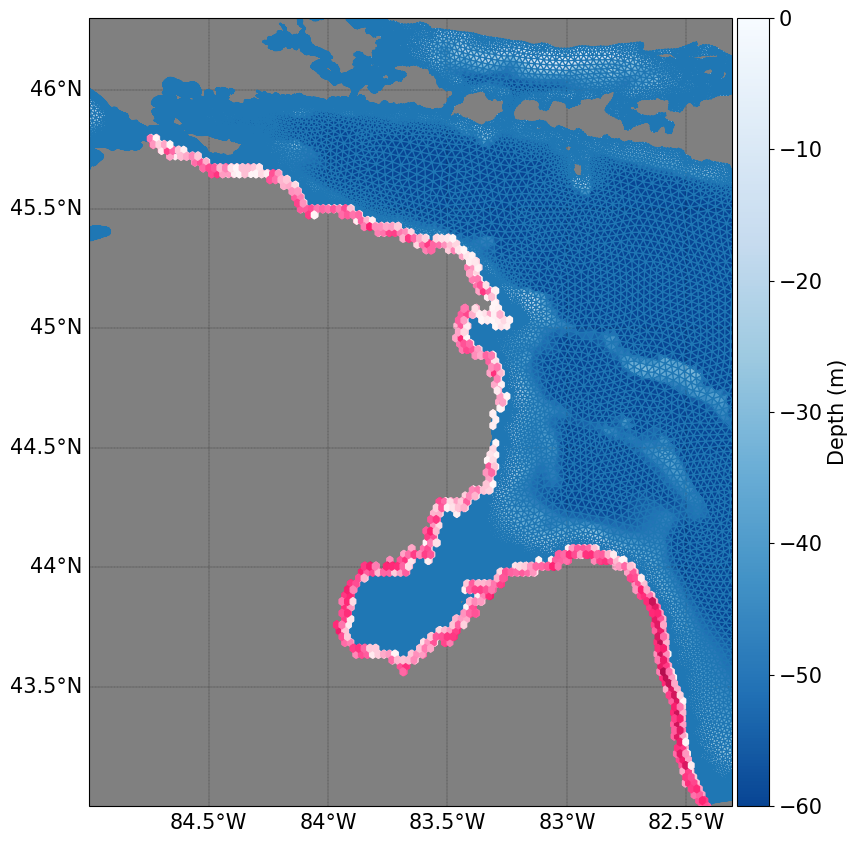

In [24]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import numpy as np
from pylag.processing.plot import FVCOMPlotter, create_figure, colourmap
import cartopy.crs as ccrs
from netCDF4 import Dataset
from pylag.processing.utils import get_grid_bands

# Load your monthly GeoDataFrames
monthly_data = {
    'Jan': combined_gdf_Jan,
    'Feb': combined_gdf_Feb,
    'Mar': combined_gdf_Mar,
    # Add more months as needed
}

# Ensure all GeoDataFrames use the same CRS
buffer_gdf_crs = buffer_gdf.crs

# DataFrame to store particle counts for each polygon across all months
all_particle_counts = pd.DataFrame(columns=['index_right', 'count'])

# Define a list of pink shades for the colormap
pink_shades = ['#fff5f7', '#ffebf0', '#ffd6e1', '#ffbfd4', '#ff99c1', '#ff6ea9', '#ff4c92', '#ff2171', '#b50d4e']
# Create a custom colormap
pink_cmap = LinearSegmentedColormap.from_list('custom_pink', pink_shades)

# Define a list of blue shades for the colormap and reverse it
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]
# Create a custom colormap
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue_reversed', blue_shades_reversed)

total_particles_intersecting_buffer = 0
total_particles_tracked = 0
points_within_shoreline_list = []
total_particles_list = []

# Store the hexbin data for each month to calculate the average
all_bin_counts = []

# Collect all coordinates for a consistent hexbin grid
all_coords = []

# Dictionary to store the first intersection time and particle count for each group_id
intersection_data = {}

# Iterate over each month's data
for month, combined_gdf in monthly_data.items():
    # Ensure 'time' is a column and convert to datetime
    if 'time' in combined_gdf.index.names:
        combined_gdf.reset_index(inplace=True)
    combined_gdf['time'] = pd.to_datetime(combined_gdf['time'])
    
    # Perform spatial join to find which points fall within the coastal buffer
    points_within_shoreline = gpd.sjoin(combined_gdf, buffer_gdf[['geometry']], how='inner', predicate='intersects')
    
    # Ensure 'time' is a column in the intersections and convert to datetime
    if 'time' in points_within_shoreline.index.names:
        points_within_shoreline.reset_index(inplace=True)
    points_within_shoreline['time'] = pd.to_datetime(points_within_shoreline['time'])
    
    # Sort the intersection by time to find the first intersection for all particles
    points_within_shoreline = points_within_shoreline.sort_values(by='time')
    
    # Identify the first intersection time and count of particles for each group_id
    first_intersection_for_month = points_within_shoreline.groupby('group_id')['time'].min()
    count_particles_for_month = points_within_shoreline.groupby('group_id').size()
    
    for group_id in first_intersection_for_month.index:
        first_time = first_intersection_for_month[group_id]
        count_particles = count_particles_for_month[group_id]
        
        if group_id not in intersection_data or first_time < intersection_data[group_id]['time']:
            intersection_data[group_id] = {'time': first_time, 'count': count_particles}
    
    # Create a GeoDataFrame for the first intersections using the same CRS
    geometry = gpd.points_from_xy(points_within_shoreline['longitude'], points_within_shoreline['latitude'], crs=buffer_gdf_crs)
    first_intersections_shoreline = gpd.GeoDataFrame(points_within_shoreline, geometry=geometry, crs=buffer_gdf_crs)
    
    # Collect coordinates for hexbin grid
    all_coords.extend(zip(first_intersections_shoreline.geometry.x, first_intersections_shoreline.geometry.y))

# Convert the dictionary to a DataFrame
intersection_df = pd.DataFrame.from_dict(intersection_data, orient='index').reset_index()
intersection_df.columns = ['Group ID', 'Time', 'Count']

# Save the DataFrame to a CSV file
intersection_df.to_csv('/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/results/intersection_times_and_counts.csv', index=False)

font_size = 15
cmap = colourmap('h_r')

# Create the figure and axis with FVCOM plotter
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Load bathymetry data
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)
extents = np.array([275, 277.69, 43, 46.3], dtype=float )
ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)', vmin=-60., vmax=0., cmap=blue_cmap_reversed, zorder= 0)

# Overlay grid
plotter.draw_grid(ax, linewidth=1.0)

# Create a hexbin plot to get the consistent grid
hb = ax.hexbin(*zip(*all_coords), gridsize=100, cmap=pink_cmap, norm=LogNorm())
hexbin_grid = hb.get_offsets()

# Initialize an array to accumulate bin counts
accumulated_bin_counts = np.zeros(len(hexbin_grid))

# Iterate over each month's data again to accumulate counts
for month, combined_gdf in monthly_data.items():
    # Ensure 'time' is a column and convert to datetime
    if 'time' in combined_gdf.index.names:
        combined_gdf.reset_index(inplace=True)
    combined_gdf['time'] = pd.to_datetime(combined_gdf['time'])
    
    # Perform spatial join to find which points fall within the coastal buffer
    points_within_shoreline = gpd.sjoin(combined_gdf, buffer_gdf[['geometry']], how='inner', predicate='intersects')
    
    # Ensure 'time' is a column in the intersections and convert to datetime
    if 'time' in points_within_shoreline.index.names:
        points_within_shoreline.reset_index(inplace=True)
    points_within_shoreline['time'] = pd.to_datetime(points_within_shoreline['time'])
    
    # Sort the intersection by time to find the first intersection for all particles
    points_within_shoreline = points_within_shoreline.sort_values(by='time')
    
    # Create a GeoDataFrame for the first intersections using the same CRS
    geometry = gpd.points_from_xy(points_within_shoreline['longitude'], points_within_shoreline['latitude'], crs=buffer_gdf_crs)
    first_intersections_shoreline = gpd.GeoDataFrame(points_within_shoreline, geometry=geometry, crs=buffer_gdf_crs)
    
    # Create a hexbin plot with the consistent grid and accumulate counts
    hb = ax.hexbin(first_intersections_shoreline.geometry.x, first_intersections_shoreline.geometry.y, gridsize=100, cmap=pink_cmap, norm=LogNorm(), reduce_C_function=np.sum, zorder=40)
    bin_counts = hb.get_array()
    for i, count in enumerate(bin_counts):
        accumulated_bin_counts[i] += count
    
    # Calculate the total number of particles that intersect the shoreline buffer
    total_particles_intersecting_buffer += first_intersections_shoreline['group_id'].nunique()
    
    # Calculate the total number of particles tracked in the month
    total_particles_tracked += combined_gdf['group_id'].nunique()
    total_particles_list.append(combined_gdf.shape[0])
    points_within_shoreline_list.append(first_intersections_shoreline.shape[0])

# Calculate the average bin counts
average_bin_counts = accumulated_bin_counts / len(monthly_data)

# Calculate the average number of particles entering the shoreline buffer
average_particles_entering_shoreline = total_particles_intersecting_buffer / len(monthly_data)

# Calculate the percentage of particles from the total trajectories that remain in the shoreline buffer
percentage_particles_remain_in_shoreline = (total_particles_intersecting_buffer / total_particles_tracked) * 100

print(f'Average number of particles entering the shoreline: {average_particles_entering_shoreline}')
print(f'Percentage of particles from total trajectories that remain in the shoreline')

#### Part 3-3-1: In this part we are going to calculate when the particles first hit the shoreline

In [106]:
# print the crs of ds
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()

In [108]:
grid_metrics_file_name

'/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc'

In [ ]:
# print the points_within_shoreline columns
print(points_within_shoreline.columns)


In [ ]:
# sort intersections by group_id and time
points_within_shoreline = points_within_shoreline.sort_values(by=['group_id', 'time'])

In [ ]:
# Group by group_id and then find the fosrt intersection for each group 
# this willl keep only thr fisrt intersection for each group at each time step
first_intersections = points_within_shoreline.groupby(['group_id','time']).first().reset_index()

In [ ]:
first_intersections

In [ ]:
# save the earliest_intersection to a csv file
first_intersections.to_csv('/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output/earliest_intersections.csv')

In [ ]:
#Print the points_within_shoreline with group_id 0
points_within_shoreline[points_within_shoreline['group_id'] == 2]
# Plot the points_within_shoreline with group_id 0
points_within_shoreline[points_within_shoreline['group_id'] == 2].plot()


In [ ]:
# Count the number of points that fall within the polygons
num_points_within_shoreline = points_within_shoreline

# Print the resulting GeoDataFrame
print(f"Number of points within shoreline: {num_points_within_shoreline.shape[0]}")
# print the total number of points from the combined_gdf
print(f"Total number of particle points: {combined_gdf.shape[0]}")
print(f"points within shoreline: {num_points_within_shoreline}")

# print the combined_gdf group_id that fall within the polygons with Watershed
print(points_within_shoreline[['longitude', 'latitude', 'group_id']])

In [ ]:
# Count the number of points that fall within the polygons
num_points_within_shoreline = earliest_intersection

# Print the resulting GeoDataFrame
print(f"Number of points within shoreline: {num_points_within_shoreline.shape[0]}")
# print the total number of points from the combined_gdf
print(f"Total number of particle points: {combined_gdf.shape[0]}")
print(f"points within shoreline: {num_points_within_shoreline}")

# print the combined_gdf group_id that fall within the polygons with Watershed
print(points_within_shoreline[['longitude', 'latitude', 'group_id']])

In [ ]:
# make a bar chart that shows the number of points that fall within the polygons and the total number of points
# Create a bar chart and make the number of points log scale
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.bar(['Total Trajectories', 'Trajectories within Shoreline'], [combined_gdf.shape[0], num_points_within_shoreline.shape[0]])
plt.ylabel('Total number of trajectories')
plt.title('Number of trajectories within Shoreline Jan 2023')
plt.show()

In [ ]:
#make a seaborn  plot showing all the data points vesus the points that fall within the polygons
import seaborn as sns
import matplotlib.pyplot as plt

# Create a plot
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sns.scatterplot(data=combined_gdf, x='longitude', y='latitude', hue='group_id', palette='tab20', ax=ax)
sns.scatterplot(data=points_within_shoreline, x='longitude', y='latitude', hue='group_id', palette='tab20', ax=ax, marker='x', s=100)

# Add a title
ax.set_title('DParticle tracking Points vs Points Within Polygons')

# Adjust the legend to have two columns
plt.legend(loc='upper left', ncol=2)

plt.show()

### part 3-4: Finding the intersection of particle tracking and coastal Wetlands 

In [84]:
# Add the Great lake shapefile 
#basin = gpd.read_file('/home/abolmaal/data/FVCOME_OUTPUT/shapefiles/Basins/glbasins_gen.shp')
lake = gpd.read_file('/home/abolmaal/data/FVCOME_OUTPUT/shapefiles/Basins/hydro_p_LakeHuron/hydro_p_LakeHuron_84.shp')
# print the basin and lake crs
#print(basin.crs)
print(lake.crs)

EPSG:4326


Average number of particles entering the Coastal Wetland: 114.66666666666667
Percentage of particles from total trajectories that remain in the Coastal Wetland: 0.87%


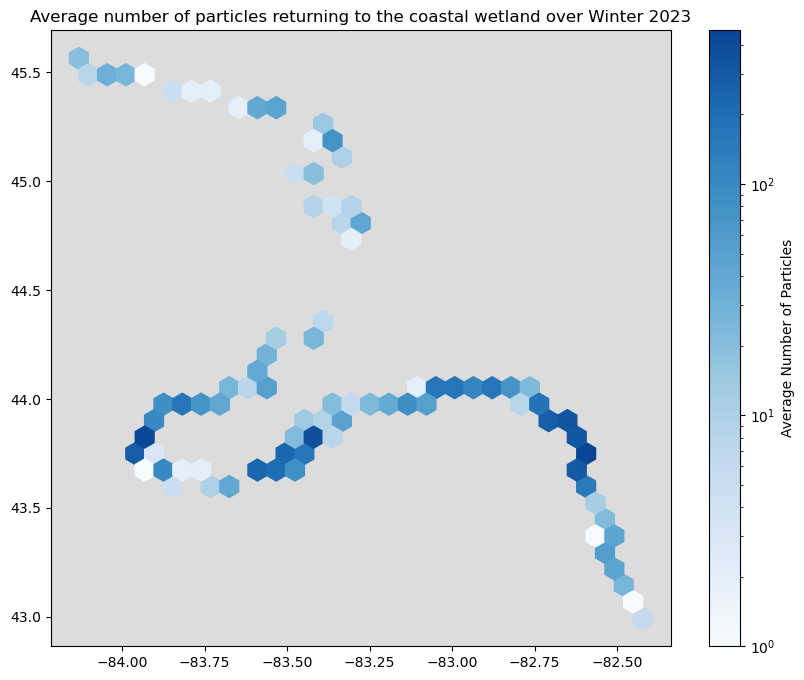

In [110]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm

# Load your monthly GeoDataFrames
monthly_data = {
    'Jan': combined_gdf_Jan,
    'Feb': combined_gdf_Feb,
    'Mar': combined_gdf_Mar,
    # Add more months as needed
}

# Coastal wetland data


# DataFrame to store particle counts for each polygon across all months
all_particle_counts = pd.DataFrame(columns=['index_right', 'count'])

# Define a list of blue shades for the colormap
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
# Create a custom colormap
blue_cmap = LinearSegmentedColormap.from_list('custom_blue', blue_shades)

total_particles_intersecting_CW = 0
total_particles_tracked = 0
points_within_CW_list = []
total_particles_list = []

# Iterate over each month's data
for month, combined_gdf in monthly_data.items():
    # Ensure 'time' is a column and convert to datetime
    if 'time' in combined_gdf.index.names:
        combined_gdf.reset_index(inplace=True)
    combined_gdf['time'] = pd.to_datetime(combined_gdf['time'])
    
    # Perform spatial join to find which points fall within the coastal wetland
    points_within_CW = gpd.sjoin(combined_gdf, CW_geo[['geometry']], how='inner', predicate='intersects')
    
    # Ensure 'time' is a column in the intersections and convert to datetime
    if 'time' in points_within_CW.index.names:
        points_within_CW.reset_index(inplace=True)
    points_within_CW['time'] = pd.to_datetime(points_within_CW['time'])
    
    # Sort the intersection by time to find the first intersection for all particles
    points_within_CW= points_within_CW.sort_values(by='time')
    
    # Get the first intersection for all particles
    first_intersections_CW = points_within_CW.groupby('geometry').first().reset_index()
    
    # Count the number of particles entering each polygon (shoreline area)
    particle_counts = first_intersections_CW['index_right'].value_counts().reset_index()
    particle_counts.columns = ['index_right', 'count']
    
    # Calculate the total number of particles that intersect the shoreline buffer
    total_particles_intersecting_CW += first_intersections_CW['group_id'].nunique()
    
    # Calculate the total number of particles tracked in the month
    total_particles_tracked += combined_gdf['group_id'].nunique()
    total_particles_list.append(combined_gdf.shape[0])
    points_within_CW_list.append(first_intersections_CW.shape[0])
# Calculate the average number of particles entering the shoreline buffer
average_particles_entering_CW = total_particles_intersecting_CW / len(monthly_data)

# Calculate the percentage of particles from the total trajectories that remain in the shoreline buffer
percentage_particles_remain_in_CW = (total_particles_intersecting_CW / total_particles_tracked) 

print(f'Average number of particles entering the Coastal Wetland: {average_particles_entering_CW}')
print(f'Percentage of particles from total trajectories that remain in the Coastal Wetland: {percentage_particles_remain_in_CW:.2f}%')


# Plot the average number of particles entering the coastal wetland
fig, ax = plt.subplots(figsize=(10, 8))

# Create the hexbin plot
hb = ax.hexbin(first_intersections_CW['longitude'], first_intersections_CW['latitude'], gridsize=30, cmap=blue_cmap, norm=LogNorm())
#plot the buffer_gdf
#buffer_gdf.boundary.plot(ax=ax, edgecolor='black')
# plot the lake_gdf based on latitude and longitude in the geoDataFrame
  
# Set the title of the colormap to the average number of particles that fall within the polygons
ax.set_title('Average number of particles returning to the coastal wetland over Winter 2023')

# Add a colorbar
cbar = fig.colorbar(hb)
cbar.set_label('Average Number of Particles')
plt.gca().set_facecolor('gainsboro')
plt.savefig('/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/results/average_number_of_particles_entering_coastal_wetland.png')
# Show the plot
plt.show()


In [18]:
import os
#data_dir = '/home/samin/data/FVCOME_OUTPUT/Gldata/FVCOMEDATA/202301'.format(os.environ['HOME'])
data_dir='/home/abolmaal/data/FVCOME_OUTPUT/Gldata/FVCOMEDATA/202301'.format(os.environ['HOME']) 
# Create run directory
cwd = os.getcwd()
# Create run directory
simulation_dir = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron'.format(cwd)
try:
    os.makedirs(simulation_dir)
except FileExistsError:
    pass

# Create input sub-directory
input_dir = '{}/input'.format(simulation_dir)
try:
    os.makedirs(input_dir)
except FileExistsError:
    pass
grid_metrics_file_name = f'{input_dir}/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc'


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Average number of particles entering the Coastal Wetland: 114.66666666666667
Percentage of particles from total trajectories that remain in the Coastal Wetland: 86.87%
Average number of particles in each bin:
Bin 0: 0.00 particles
Bin 1: 0.00 particles
Bin 2: 0.00 particles
Bin 3: 0.00 particles
Bin 4: 0.00 particles
Bin 5: 0.00 particles
Bin 6: 0.00 particles
Bin 7: 0.00 particles
Bin 8: 0.00 particles
Bin 9: 0.00 particles
Bin 10: 0.00 particles
Bin 11: 0.00 particles
Bin 12: 0.00 particles
Bin 13: 0.00 particles
Bin 14: 0.00 particles
Bin 15: 0.00 particles
Bin 16: 0.00 particles
Bin 17: 0.00 particles
Bin 18: 0.00 particles
Bin 19: 0.00 particles
Bin 20: 0.00 particles
Bin 21: 0.00 particles
Bin 22: 0.00 particles
Bin 23: 0.00 particles
Bin 24: 0.00 particles
Bin 25: 0.00 particles
Bin 26: 0.00 particles
Bin 27: 0.00 particles
Bin 28: 0.00 particles
Bin 29: 0.00 particles
Bin 30: 0.00 particles
Bin 31: 0.00 particles
Bin 32: 0.00 particles
Bin 33: 0.00 particles
Bin 34: 0.00 partic

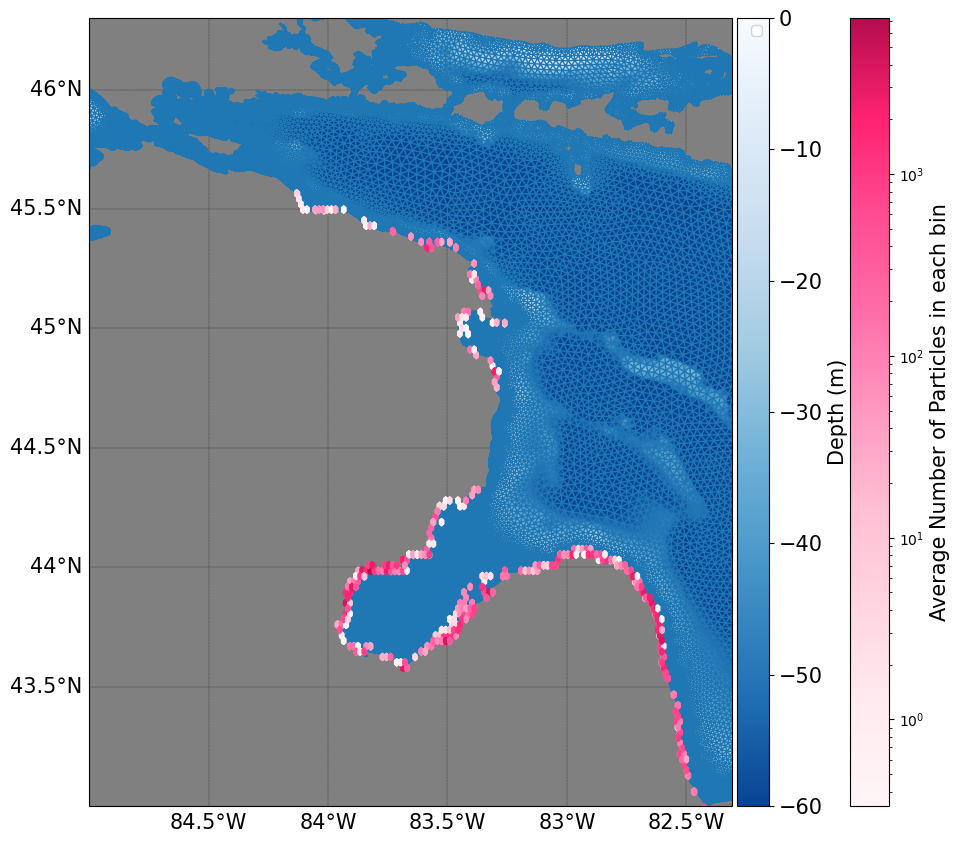

In [32]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import numpy as np
from pylag.processing.plot import FVCOMPlotter
from pylag.processing.plot import create_figure, colourmap
import cartopy.crs as ccrs
from netCDF4 import Dataset
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from pylag.regrid import regridder
from pylag.processing.ncview import Viewer
from pylag.processing.plot import FVCOMPlotter
from pylag.processing.plot import create_figure
from pylag.processing.utils import get_grid_bands

# Load your monthly GeoDataFrames
monthly_data = {
    'Jan': combined_gdf_Jan,
    'Feb': combined_gdf_Feb,
    'Mar': combined_gdf_Mar,
    # Add more months as needed
}
# Ensure all GeoDataFrames use the same CRS
CW_geo_crs = CW_geo.crs


# DataFrame to store particle counts for each polygon across all months
all_particle_counts = pd.DataFrame(columns=['index_right', 'count'])

# Define a list of pink shades for the colormap
pink_shades = ['#fff5f7', '#ffebf0', '#ffd6e1', '#ffbfd4', '#ff99c1', '#ff6ea9', '#ff4c92', '#ff2171', '#b50d4e']
# Create a custom colormap
pink_cmap = LinearSegmentedColormap.from_list('custom_pink', pink_shades)
# Define a list of blue shades for the colormap
# Define a list of blue shades for the colormap
# Define a list of blue shades for the colormap and reverse it
# Define a list of blue shades for the colormap and reverse it
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]
# Create a custom colormap
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue_reversed', blue_shades_reversed)



total_particles_intersecting_CW = 0
total_particles_tracked = 0
points_within_CW_list = []
total_particles_list = []

# Store the hexbin data for each month to calculate the average
all_bin_counts = []

# Collect all coordinates for a consistent hexbin grid
all_coords = []

# Iterate over each month's data
for month, combined_gdf in monthly_data.items():
    # Ensure 'time' is a column and convert to datetime
    if 'time' in combined_gdf.index.names:
        combined_gdf.reset_index(inplace=True)
    combined_gdf['time'] = pd.to_datetime(combined_gdf['time'])
    
    # Perform spatial join to find which points fall within the coastal wetland
    points_within_CW = gpd.sjoin(combined_gdf, CW_geo[['geometry']], how='inner', predicate='intersects')
    
    # Ensure 'time' is a column in the intersections and convert to datetime
    if 'time' in points_within_CW.index.names:
        points_within_CW.reset_index(inplace=True)
    points_within_CW['time'] = pd.to_datetime(points_within_CW['time'])
    
    # Sort the intersection by time to find the first intersection for all particles
    points_within_CW = points_within_CW.sort_values(by='time')
    
    # Create a GeoDataFrame for the first intersections using the same CRS
    geometry = gpd.points_from_xy(points_within_CW['longitude'], points_within_CW['latitude'], crs=CW_geo_crs)
    first_intersections_CW = gpd.GeoDataFrame(points_within_CW, geometry=geometry, crs=CW_geo_crs)
    
    # Collect coordinates for hexbin grid
    all_coords.extend(zip(first_intersections_CW.geometry.x, first_intersections_CW.geometry.y))

font_size = 15
cmap = colourmap('h_r')

# Create the figure and axis with FVCOM plotter
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Load bathymetry data
grid_metrics_file_name = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc'

ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)
extents = np.array([275, 277.69, 43, 46.3], dtype=float)
ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)', vmin=-60., vmax=0., cmap=blue_cmap_reversed,zorder=0)

# Overlay grid
plotter.draw_grid(ax, linewidth=1.0)

# Create a hexbin plot to get the consistent grid
hb = ax.hexbin(*zip(*all_coords), gridsize=100, cmap=pink_cmap, norm=LogNorm())
hexbin_grid = hb.get_offsets()

# Initialize an array to accumulate bin counts
accumulated_bin_counts = np.zeros(len(hexbin_grid))

# Iterate over each month's data again to accumulate counts
for month, combined_gdf in monthly_data.items():
    # Ensure 'time' is a column and convert to datetime
    if 'time' in combined_gdf.index.names:
        combined_gdf.reset_index(inplace=True)
    combined_gdf['time'] = pd.to_datetime(combined_gdf['time'])
    
    # Perform spatial join to find which points fall within the coastal wetland
    points_within_CW = gpd.sjoin(combined_gdf, CW_geo[['geometry']], how='inner', predicate='intersects')
    
    # Ensure 'time' is a column in the intersections and convert to datetime
    if 'time' in points_within_CW.index.names:
        points_within_CW.reset_index(inplace=True)
    points_within_CW['time'] = pd.to_datetime(points_within_CW['time'])
    
    # Sort the intersection by time to find the first intersection for all particles
    points_within_CW = points_within_CW.sort_values(by='time')
    
    # Create a GeoDataFrame for the first intersections using the same CRS
    geometry = gpd.points_from_xy(points_within_CW['longitude'], points_within_CW['latitude'], crs=CW_geo_crs)
    first_intersections_CW = gpd.GeoDataFrame(points_within_CW, geometry=geometry, crs=CW_geo_crs)
    
    # Create a hexbin plot with the consistent grid and accumulate counts
    hb = ax.hexbin(first_intersections_CW.geometry.x, first_intersections_CW.geometry.y, gridsize=100, cmap=pink_cmap, norm=LogNorm(), reduce_C_function=np.sum, zorder = 40)
    bin_counts = hb.get_array()
    for i, count in enumerate(bin_counts):
        accumulated_bin_counts[i] += count
    
    # Calculate the total number of particles that intersect the shoreline buffer
    total_particles_intersecting_CW += first_intersections_CW['group_id'].nunique()
    
    # Calculate the total number of particles tracked in the month
    total_particles_tracked += combined_gdf['group_id'].nunique()
    total_particles_list.append(combined_gdf.shape[0])
    points_within_CW_list.append(first_intersections_CW.shape[0])

# Calculate the average bin counts
average_bin_counts = accumulated_bin_counts / len(monthly_data)

# Calculate the average number of particles entering the shoreline buffer
average_particles_entering_CW = total_particles_intersecting_CW / len(monthly_data)

# Calculate the percentage of particles from the total trajectories that remain in the shoreline buffer
percentage_particles_remain_in_CW = (total_particles_intersecting_CW / total_particles_tracked) * 100

print(f'Average number of particles entering the Coastal Wetland: {average_particles_entering_CW}')
print(f'Percentage of particles from total trajectories that remain in the Coastal Wetland: {percentage_particles_remain_in_CW:.2f}%')

# Update the hexbin plot with average bin counts
hb = ax.hexbin(*zip(*hexbin_grid), gridsize=100, C=average_bin_counts, cmap=pink_cmap, norm=LogNorm(), zorder=40)

# Print the average number of particles in each bin
print("Average number of particles in each bin:")
for i, count in enumerate(average_bin_counts):
    print(f"Bin {i}: {count:.2f} particles")

# Set the title of the colormap to the average number of particles that fall within the polygons
#ax.set_title('Average number of particles returning to the coastal wetland over Winter 2023')

# Add x and y labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add a colorbar
cbar = fig.colorbar(hb, ax=ax, pad=0.09)
cbar.set_label('Average Number of Particles in each bin', fontsize=15)

# Adjust layout to make space for colorbar
plt.subplots_adjust(right=1)

# Add legend
plt.legend()

# Show the plot
plt.show()


<Figure size 2000x1800 with 0 Axes>

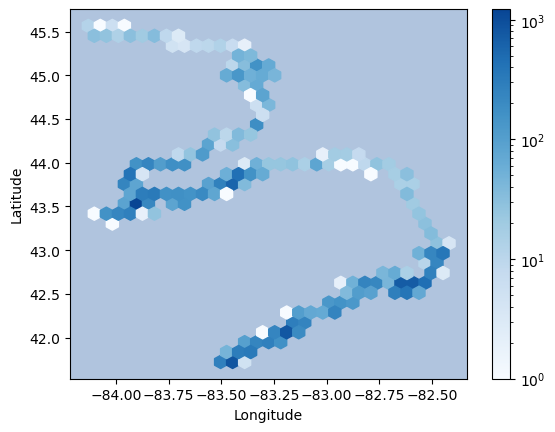

In [78]:
#Define a list of purple shades
#purple_shades = ['purple', 'violet', 'plum', 'thistle', 'mediumslateblue', 'darkorchid', 'mediumpurple', 'slateblue']
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
#blue_shades= ['royalblue','slateblue', 'mediumslateblue','mediumslateblue', 'mediumpurple','mediumorchid','plum']

# Create a custom colormap
blue_cmap = LinearSegmentedColormap.from_list('custom_blue', blue_shades)
# plot hexbin map of coastal wetland with the color range of purple shades and the name of cmpap is Coastal Wetland density 
plt.figure(figsize=(20, 18))
CW_geo.plot.hexbin(x='Start_Lon', y='Start_Lat', gridsize=30, cmap=blue_cmap,  norm=colors.LogNorm())
plt.gca().set_facecolor('lightsteelblue')
#plt.title('Coastal Wetlands Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/results/CoastalWetlandsDensity.png')
plt.show()
# save the plot to a data_dir directory


In [59]:
# Load bathymetry data
grid_metrics_file_name = f'{input_dir}/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc'
ds = Dataset(grid_metrics_file_name, 'r')
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: PyLag grid metrics file
    netcdf-version-id: netCDF-4
    pylag-version-id: 6333d9db6f491a275cdc5709d76399ba9a6badc8
    is_global: False
    dimensions(sizes): three(3), node(90806), element(171377), siglay(20), siglev(21)
    variables(dimensions): float32 x(node), float32 y(node), float32 longitude(node), float32 latitude(node), float32 xc(element), float32 yc(element), float32 longitude_c(element), float32 latitude_c(element), float32 siglay(siglay, node), float32 h(node), float32 siglev(siglev, node), int64 nv(three, element), float64 area(element), int64 nbe(three, element), int64 mask_c(element)
    groups: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


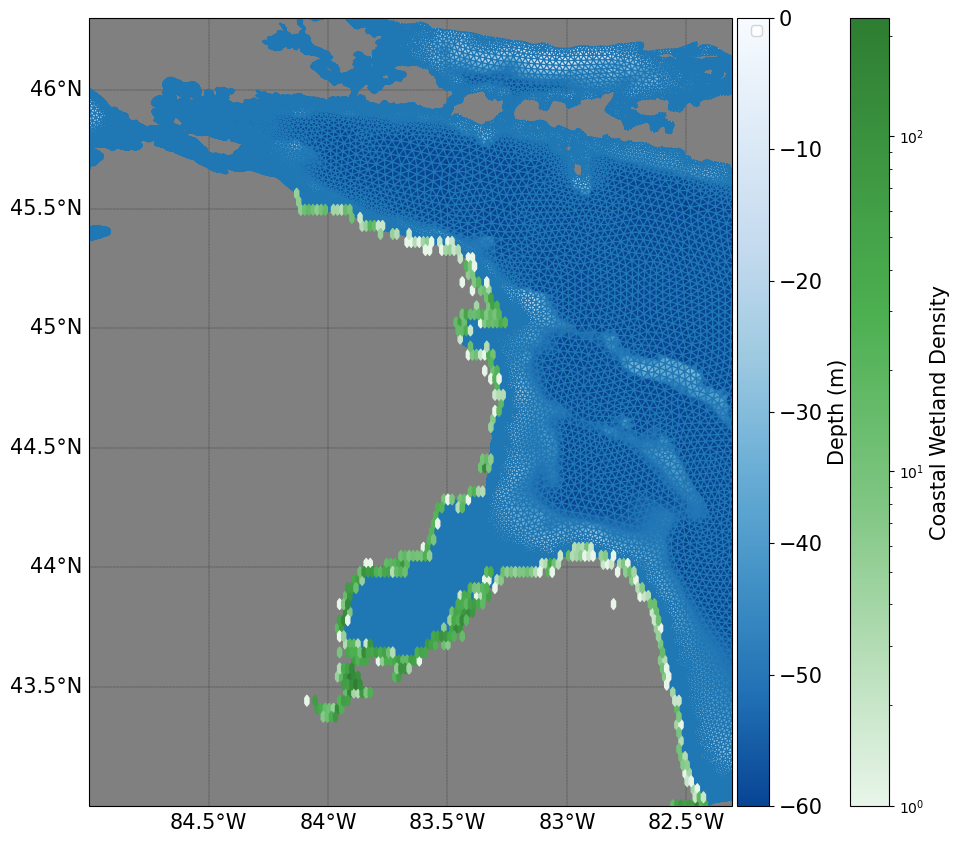

In [34]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from netCDF4 import Dataset
import cartopy.crs as ccrs

# Define a list of pink shades for the colormap
pink_shades = ['#fff5f7', '#ffebf0', '#ffd6e1', '#ffbfd4', '#ff99c1', '#ff6ea9', '#ff4c92', '#ff2171', '#b50d4e']
# Create a custom colormap
pink_cmap = LinearSegmentedColormap.from_list('custom_pink', pink_shades)

# Define a list of blue shades for the colormap and reverse it
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]

# Define a list of green shades for the colormap
green_shades = ['#e8f5e9', '#c8e6c9', '#a5d6a7', '#81c784', '#66bb6a', '#4caf50', '#43a047', '#388e3c', '#2e7d32']
# Create a custom colormap
green_cmap = LinearSegmentedColormap.from_list('custom_green', green_shades)

# Create a custom colormap
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue_reversed', blue_shades_reversed)
font_size = 15
cmap = colourmap('h_r')

# Create the figure and axis with FVCOM plotter
fig, ax = create_figure( figure_size=(26.,26.),projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Load bathymetry data
grid_metrics_file_name = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc'
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()
# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                       geographic_coords=True,
                       font_size=font_size)

# Plot bathymetry
#extents = np.array([-84.10,-84.20, 45.58,45.65], dtype=float)
#extensts = np.array([-84,-81.3, 43,46], dtype=float)
#Lake Huron Ausable Point
extents = np.array([275, 277.69, 43, 46.3], dtype=float)
ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
                              vmin=-60., vmax=0., cmap=blue_cmap_reversed, zorder = 0)

# Overlay grid
plotter.draw_grid(ax, linewidth=1.0)


# Plot the coastal wetland data with hexbin
hb = ax.hexbin(CW_geo['Start_Lon'], CW_geo['Start_Lat'], gridsize=100, cmap=green_cmap, norm=LogNorm(), zorder=40)

# Add a colorbar
cbar = fig.colorbar(hb, ax=ax, pad=0.09)
cbar.set_label('Coastal Wetland Density',fontsize=15)

# Adjust layout to make space for colorbar
plt.subplots_adjust(right=1)

# Add legend
plt.legend()

# Show the plot
plt.show()
